In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
nclass=1
n5=8
def readDBabse(nclass):
    with nc.Dataset("stratiformProfiles.nc") as fh:
        zm=fh.variables["zkum%2.2i"%nclass][:,:-n5]
        pRate=fh.variables["pRate%2.2i"%nclass][:,:-n5]
    zm[zm<0]=0
    FL=168+2*nclass
    return zm,pRate,FL

In [2]:
zm_1,pRate_1,FL_1=readDBabse(nclass)
zm_2,pRate_2,FL_2=readDBabse(nclass+1)
zm_3,pRate_3,FL_3=readDBabse(nclass+2)
zm_4,pRate_4,FL_4=readDBabse(nclass+3)
zm_5,pRate_5,FL_5=readDBabse(nclass+4)
print(zm.shape)
k=nclass
zm_1[zm_1<0]=0
zm_2[zm_2<0]=0
zm_3[zm_3<0]=0
zm_4[zm_4<0]=0
zm_5[zm_5<0]=0
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(zm_1.mean(axis=0)[:(86-n5)],np.arange(86-n5)+2*k-70)
plt.plot(zm_1.mean(axis=0)[:(86-n5)][-8:],(np.arange(86-n5)+2*k-70)[-8:],'*')
plt.ylim(10,-40)
plt.grid()
plt.subplot(122)
plt.plot(pRate_1.mean(axis=0)[:(86-n5)],np.arange(86-n5)+2*k-70)
plt.ylim(10,-40)
plt.grid()
zm_mean=zm_1.mean(axis=0)
#print(zm_mean)
#print(zm.shape)
binFL=70-2*k+90


NameError: name 'zm' is not defined

In [41]:
zm,pRate,FL=readDBabse(nclass)
# split zm and pRate into two parts using split_train
from sklearn.model_selection import train_test_split
X_train, X_test, iy_train, iy_test = train_test_split(zm_1, range(pRate_1.shape[0]), test_size=0.1, random_state=42)
y_train=pRate_1[iy_train]
y_test=pRate_1[iy_test]
# import kmeans
from sklearn.cluster import KMeans, MiniBatchKMeans
#import kMeansRegressor as kMR
from sklearn.neighbors import KNeighborsRegressor

nclutbin=16


In [ ]:
def getKGains(X_train,y_train,nclutbin=16):
    nClust=60
    kmeans = MiniBatchKMeans(n_clusters=nClust, random_state=0).fit(X_train[:,:-nclutbin])
    kmeans.fit(X_train[:,:-nclutbin])
    kgainL=[]
    ymL=[]
    sfcPrecipmL=[]
    correctFact=[]
    for i in range(nClust):
        a=np.where(kmeans.labels_==i)[0]
        print(len(a))
        x=X_train[a,-nclutbin-3:-nclutbin]
        y=y_train[a,-1:]
        covxy_np=np.cov(x.T,y.T)
        covyy=covxy_np[:3,:3]
        covyy+=np.eye(3)*1
        covxy=covxy_np[:3,3]
        correctFact.append(y_train[a,-1].mean()/y_train[a,-nclutbin-1].mean())
        print(covyy,covxy)
        kgain=np.dot(np.linalg.pinv(covyy),covxy)
        sfcPrecipmL.append(y_train[a,-1].mean())
        #print(kgain.shape)
        kgainL.append(kgain)
        ymL.append(X_train[a,-nclutbin-3:-nclutbin].mean())
    #print(sfcPrecipmL)
    return kgainL,ymL,correctFact,kmeans,sfcPrecipmL

kgainL,ymL,correctFact,kmeans,sfcPrecipmL=getKGains(X_train,y_train,nclutbin=nclutbin)

In [132]:
def evalKmeansCorrection(kgainL,ymL,correctFact,nclutbin,X_test,y_test):
    ilabels=kmeans.predict(X_test[:,:-nclutbin])
    yLs=[]
    for i,x1 in enumerate(X_test[:,:-nclutbin]):
        kgain=kgainL[ilabels[i]]
        ym=ymL[ilabels[i]]
        yLs.append((x1[-nclutbin-3:-nclutbin]-ym).dot(kgain)*correctFact[ilabels[i]])


from sklearn.neighbors import KNeighborsRegressor


KNeighborsRegressor(n_neighbors=20, weights='distance')

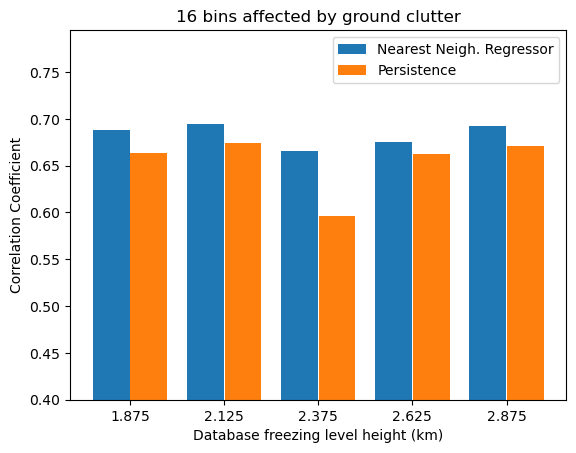

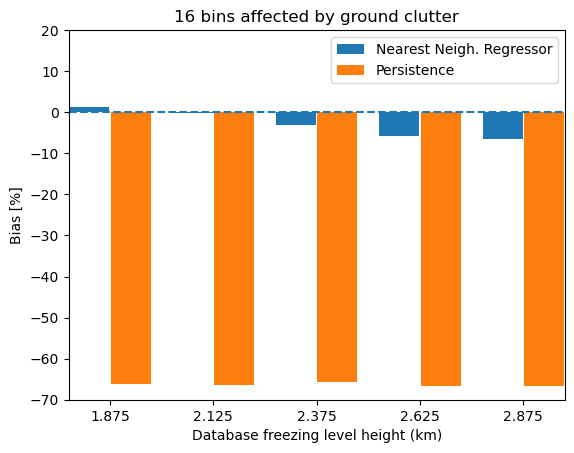

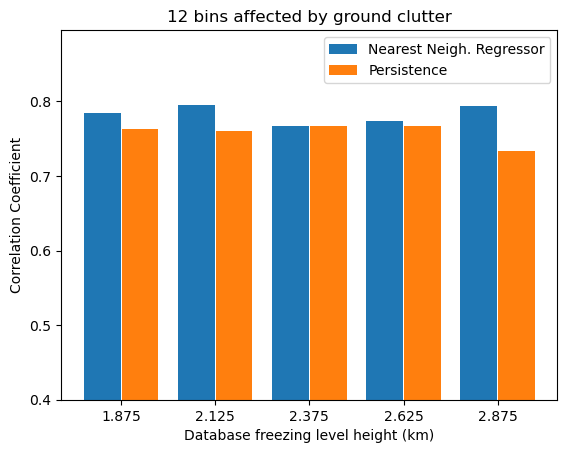

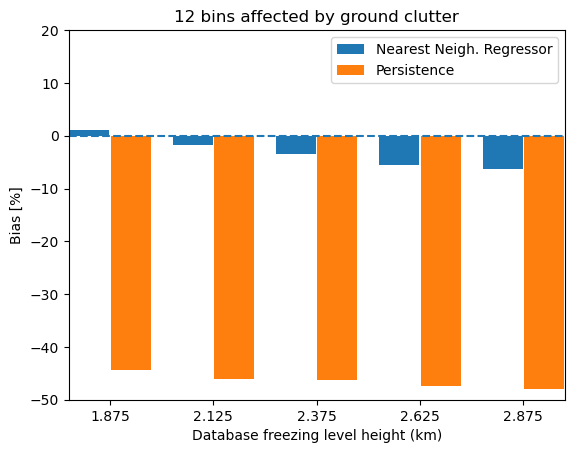

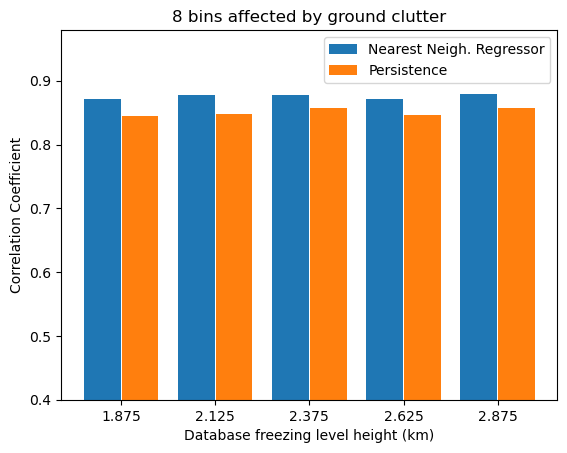

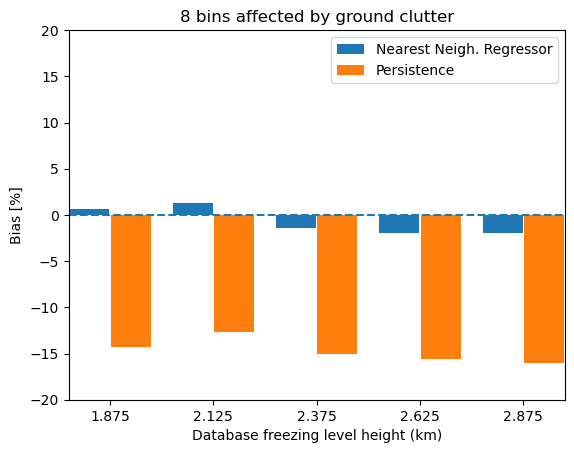

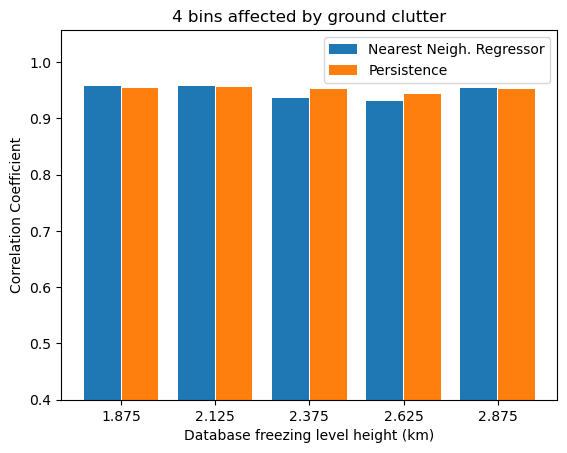

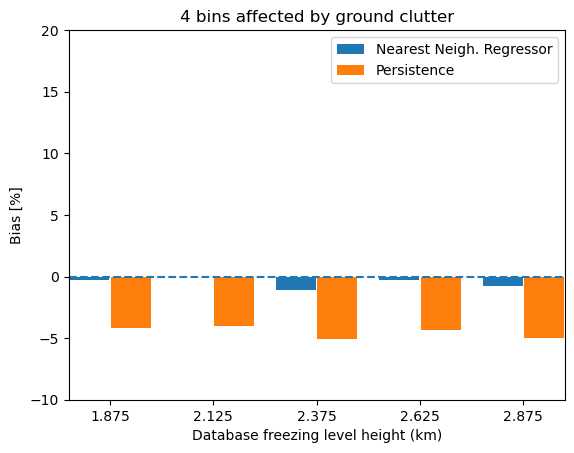

In [67]:
kMeansL=[]
resL=[]
from sklearn.ensemble import HistGradientBoostingRegressor,BaggingRegressor,RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
gbr=HistGradientBoostingRegressor(loss='absolute_error',random_state=0,max_depth=5,max_iter=1000,learning_rate=0.9,max_bins=128,l2_regularization=0.01)

for nclutbin in [16,12,8,4]:
    kMeansR=HistGradientBoostingRegressor(loss='absolute_error',random_state=0,max_depth=5)
    #kMeansR=KNeighborsRegressor(n_neighbors=20)
    kMeansR=RandomForestRegressor(n_estimators=20,max_depth=6)
    kMeansR.fit(y_train[:,-nclutbin-10:-nclutbin],y_train[:,-1])
    y_pred_1=kMeansR.predict(y_test[:,-nclutbin-10:-nclutbin])
    y_pred_2=kMeansR.predict(pRate_2[:,-nclutbin-12:-nclutbin-2])
    y_pred_3=kMeansR.predict(pRate_3[:,-nclutbin-14:-nclutbin-4])
    y_pred_4=kMeansR.predict(pRate_4[:,-nclutbin-16:-nclutbin-6])
    y_pred_5=kMeansR.predict(pRate_5[:,-nclutbin-18:-nclutbin-8])
    resNRegL=[]
    resNRegL.append([np.corrcoef(y_pred_1,y_test[:,-1])[0,1],y_pred_1.mean(),y_test[:,-1].mean()])
    resNRegL.append([np.corrcoef(y_pred_2,pRate_2[:,-3])[0,1],y_pred_2.mean(),pRate_2[:,-3].mean()])
    resNRegL.append([np.corrcoef(y_pred_3,pRate_3[:,-5])[0,1],y_pred_3.mean(),pRate_3[:,-5].mean()])
    resNRegL.append([np.corrcoef(y_pred_4,pRate_4[:,-7])[0,1],y_pred_4.mean(),pRate_4[:,-7].mean()])
    resNRegL.append([np.corrcoef(y_pred_5,pRate_5[:,-9])[0,1],y_pred_5.mean(),pRate_5[:,-9].mean()])
    resPersL=[]
    resPersL.append([np.corrcoef(y_test[:,-nclutbin-1],y_test[:,-1])[0,1],y_test[:,-nclutbin-1].mean(),y_test[:,-1].mean()])
    resPersL.append([np.corrcoef(pRate_2[:,-nclutbin-3],pRate_2[:,-3])[0,1],pRate_2[:,-nclutbin-3].mean(),pRate_2[:,-3].mean()])
    resPersL.append([np.corrcoef(pRate_3[:,-nclutbin-5],pRate_3[:,-5])[0,1],pRate_3[:,-nclutbin-5].mean(),pRate_3[:,-5].mean()])
    resPersL.append([np.corrcoef(pRate_4[:,-nclutbin-7],pRate_4[:,-7])[0,1],pRate_4[:,-nclutbin-7].mean(),pRate_4[:,-7].mean()])
    resPersL.append([np.corrcoef(pRate_5[:,-nclutbin-9],pRate_5[:,-9])[0,1],pRate_5[:,-nclutbin-9].mean(),pRate_5[:,-9].mean()])
    trainFLs=(np.arange(5)*2+15)*0.125
    resNRegL=np.array(resNRegL)
    resPersL=np.array(resPersL)
    plt.figure()
    ax=plt.subplot(111)
    p1=plt.bar(np.arange(5)-0.2,resNRegL[:,0],width=0.39,label='Random Forest Regressor')
    plt.bar(np.arange(5)+0.2,resPersL[:,0],width=0.39,label='Persistence')
    t=ax.get_xticklabels()
    ax.set_xticks(range(5),[str(s1) for s1 in trainFLs])
    plt.xlabel('Database freezing level height (km)')
    plt.ylabel('Correlation Coefficient')
    plt.ylim(0.4,resNRegL[:,0].max()+0.1)
    plt.legend()
    plt.title('%i bins affected by ground clutter'%nclutbin)
    plt.savefig('corrCoeff_%2.2ibins.png'%nclutbin)
    plt.figure()
    ax=plt.subplot(111)
    p1=plt.bar(np.arange(5)-0.2,(resNRegL[:,1]/resNRegL[:,2]-1)*100,width=0.39,label='Nearest Neigh. Regressor')
    plt.bar(np.arange(5)+0.2,(resPersL[:,1]/resPersL[:,2]-1)*100,width=0.39,label='Persistence')
    t=ax.get_xticklabels()
    ax.set_xticks(range(5),[str(s1) for s1 in trainFLs])
    plt.xlabel('Database freezing level height (km)')
    plt.plot([-0.4,4.4],[0,0],'--')
    plt.ylabel('Bias [%]')
    bias=(resPersL[:,1]/resNRegL[:,2]-1)*100
    nBias=(-bias).max()
    tBias=int(np.ceil(nBias/10.))*10
    plt.ylim(-tBias,20)
    plt.xlim(-0.4,4.4)
    plt.legend()
    plt.title('%i bins affected by ground clutter'%nclutbin)
    plt.savefig('bias_%2.2ibins.png'%nclutbin)
    resL.append([resNRegL,resPersL])
    kMeansL.append(kMeansR)

import pickle
pickle.dump({"resL":resL,"kMeansL":kMeansL},open('resL_kMeansL_%2.2ibins.pckl'%nclutbin,'wb'))

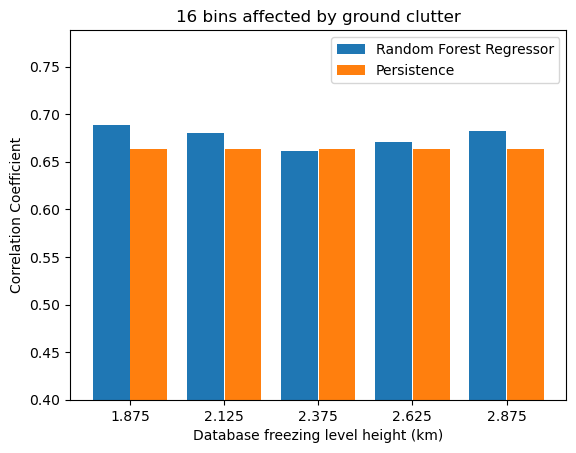

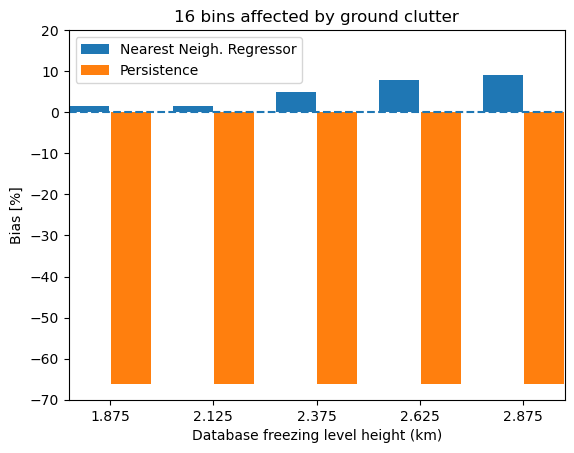

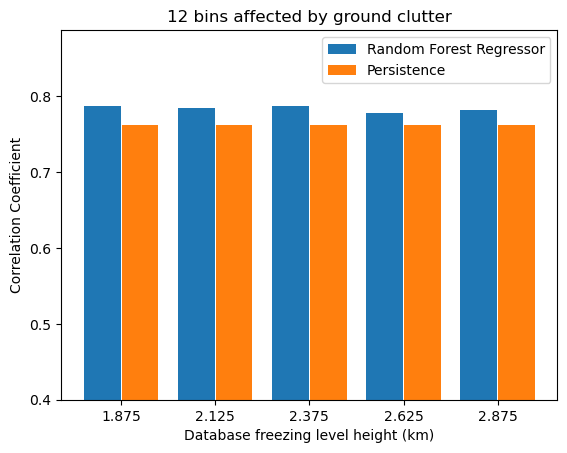

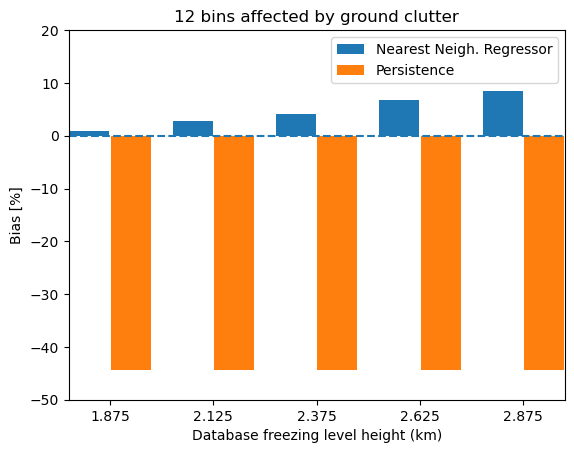

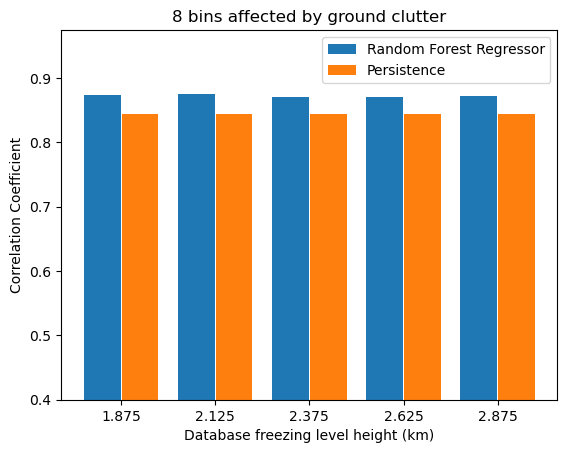

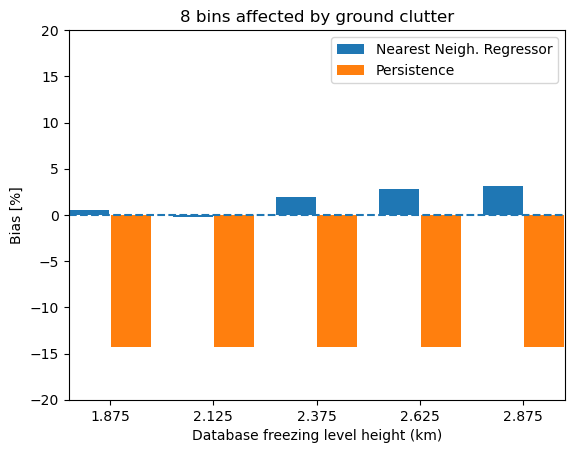

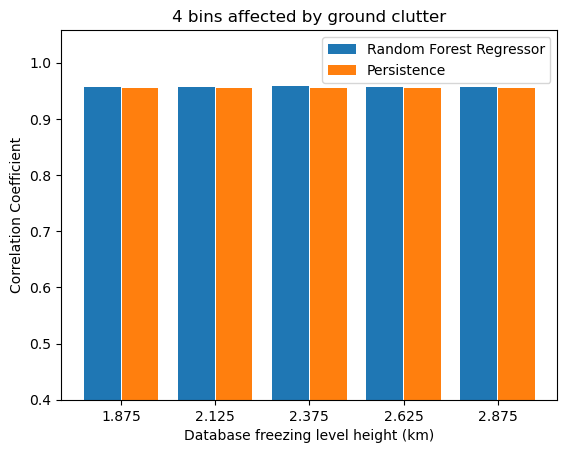

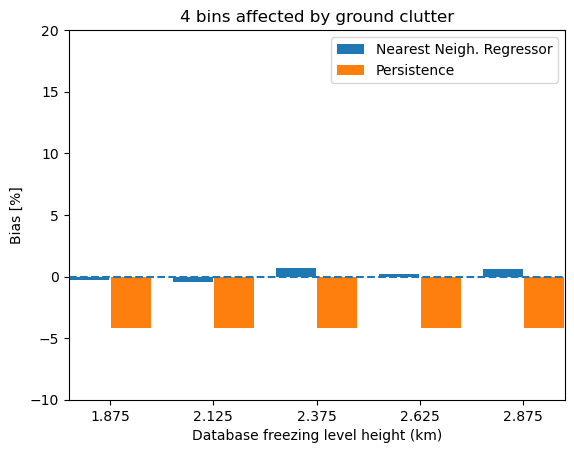

In [71]:
kMeansL=[]
resL=[]
from sklearn.ensemble import HistGradientBoostingRegressor,BaggingRegressor,RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
gbr=HistGradientBoostingRegressor(loss='absolute_error',random_state=0,max_depth=5,max_iter=1000,learning_rate=0.9,max_bins=128,l2_regularization=0.01)
biasL=[]
xbL=[]
coeffs=[0.00437727, 0.01286493] 
intercp=0.9589863024679486
for nclutbin in [16,12,8,4]:
    kMeansR=HistGradientBoostingRegressor(loss='absolute_error',random_state=0,max_depth=5)
    #kMeansR=KNeighborsRegressor(n_neighbors=20)
    resNRegL=[]
    rf1=RandomForestRegressor(n_estimators=20,max_depth=6)
    rf1.fit(y_train[:,-nclutbin-10:-nclutbin],y_train[:,-1])
    y_pred_1=rf1.predict(y_test[:,-nclutbin-10:-nclutbin])
    resNRegL.append([np.corrcoef(y_pred_1,y_test[:,-1])[0,1],y_pred_1.mean(),y_test[:,-1].mean()])

    rf2=RandomForestRegressor(n_estimators=20,max_depth=6)
    rf2.fit(pRate_2[:,-nclutbin-10-2:-nclutbin-2],pRate_2[:,-3])
    y_pred_1=rf2.predict(y_test[:,-nclutbin-10:-nclutbin])
    predBias=intercp+coeffs[0]*nclutbin+coeffs[1]*1
    resNRegL.append([np.corrcoef(y_pred_1,y_test[:,-1])[0,1],y_pred_1.mean()/predBias,y_test[:,-1].mean()])

    rf3=RandomForestRegressor(n_estimators=20,max_depth=6)
    rf3.fit(pRate_3[:,-nclutbin-10-4:-nclutbin-4],pRate_3[:,-5])
    y_pred_1=rf3.predict(y_test[:,-nclutbin-10:-nclutbin])
    predBias=intercp+coeffs[0]*nclutbin+coeffs[1]*2
    resNRegL.append([np.corrcoef(y_pred_1,y_test[:,-1])[0,1],y_pred_1.mean()/predBias,y_test[:,-1].mean()])

    rf4=RandomForestRegressor(n_estimators=20,max_depth=6)
    rf4.fit(pRate_4[:,-nclutbin-10-6:-nclutbin-6],pRate_4[:,-7])
    y_pred_1=rf4.predict(y_test[:,-nclutbin-10:-nclutbin])
    predBias=intercp+coeffs[0]*nclutbin+coeffs[1]*3
    resNRegL.append([np.corrcoef(y_pred_1,y_test[:,-1])[0,1],y_pred_1.mean()/predBias,y_test[:,-1].mean()])

    rf5=RandomForestRegressor(n_estimators=20,max_depth=6)
    rf5.fit(pRate_5[:,-nclutbin-10-8:-nclutbin-8],pRate_5[:,-9])    
    y_pred_1=rf5.predict(y_test[:,-nclutbin-10:-nclutbin])
    predBias=intercp+coeffs[0]*nclutbin+coeffs[1]*4
    resNRegL.append([np.corrcoef(y_pred_1,y_test[:,-1])[0,1],y_pred_1.mean()/predBias,y_test[:,-1].mean()])

    resPersL=[]
    resPersL.append([np.corrcoef(y_test[:,-nclutbin-1],y_test[:,-1])[0,1],y_test[:,-nclutbin-1].mean(),y_test[:,-1].mean()])
    resPersL.append([np.corrcoef(y_test[:,-nclutbin-1],y_test[:,-1])[0,1],y_test[:,-nclutbin-1].mean(),y_test[:,-1].mean()])
    resPersL.append([np.corrcoef(y_test[:,-nclutbin-1],y_test[:,-1])[0,1],y_test[:,-nclutbin-1].mean(),y_test[:,-1].mean()])
    resPersL.append([np.corrcoef(y_test[:,-nclutbin-1],y_test[:,-1])[0,1],y_test[:,-nclutbin-1].mean(),y_test[:,-1].mean()])
    resPersL.append([np.corrcoef(y_test[:,-nclutbin-1],y_test[:,-1])[0,1],y_test[:,-nclutbin-1].mean(),y_test[:,-1].mean()])
    trainFLs=(np.arange(5)*2+15)*0.125
    resNRegL=np.array(resNRegL)
    resPersL=np.array(resPersL)
    plt.figure()
    ax=plt.subplot(111)
    p1=plt.bar(np.arange(5)-0.2,resNRegL[:,0],width=0.39,label='Random Forest Regressor')
    plt.bar(np.arange(5)+0.2,resPersL[:,0],width=0.39,label='Persistence')
    t=ax.get_xticklabels()
    ax.set_xticks(range(5),[str(s1) for s1 in trainFLs])
    plt.xlabel('Database freezing level height (km)')
    plt.ylabel('Correlation Coefficient')
    plt.ylim(0.4,resNRegL[:,0].max()+0.1)
    plt.legend()
    plt.title('%i bins affected by ground clutter'%nclutbin)
    plt.savefig('corrCoeff_%2.2ibins.png'%nclutbin)
    plt.figure()
    ax=plt.subplot(111)
    p1=plt.bar(np.arange(5)-0.2,(resNRegL[:,1]/resNRegL[:,2]-1)*100,width=0.39,label='Nearest Neigh. Regressor')
    plt.bar(np.arange(5)+0.2,(resPersL[:,1]/resPersL[:,2]-1)*100,width=0.39,label='Persistence')
    t=ax.get_xticklabels()
    ax.set_xticks(range(5),[str(s1) for s1 in trainFLs])
    plt.xlabel('Database freezing level height (km)')
    plt.plot([-0.4,4.4],[0,0],'--')
    plt.ylabel('Bias [%]')
    biasM=(resNRegL[:,1]/resNRegL[:,2])
    bias=(resPersL[:,1]/resNRegL[:,2]-1)*100
    nBias=(-bias).max()
    tBias=int(np.ceil(nBias/10.))*10
    plt.ylim(-tBias,20)
    plt.xlim(-0.4,4.4)
    plt.legend()
    plt.title('%i bins affected by ground clutter'%nclutbin)
    plt.savefig('bias_%2.2ibins.png'%nclutbin)
    resL.append([resNRegL,resPersL])
    kMeansL.append(kMeansR)
    xbL.extend([[nclutbin,k] for k in range(5)])
    biasL.extend(biasM)

rfL=[rf1,rf2,rf3,rf4,rf5]
import pickle
pickle.dump({"resL":resL,"rfL":kMeansL},open('resL_rforestL_%2.2ibins.pckl'%nclutbin,'wb'))

In [73]:
print(bias)

from sklearn.linear_model import LinearRegression

regrL=LinearRegression()
regrL.fit(np.array(xbL),np.array(biasL))
print(regrL.coef_,regrL.intercept_)

[-4.18556677 -4.18556677 -4.18556677 -4.18556677 -4.18556677]
[0.00437727 0.01286493] 0.9589863024679486


In [314]:
#define a tensorflow model with 2 hidden layers 1 output layer and four neurons on input layer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import optimizers

def create_model():
    model = tf.keras.Sequential()
    model.add(Dense(32, input_dim=3, activation='relu'))
    model.add(Dropout(0.1))
    #model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(1, activation=None))
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model
# define a classifier model with 20 classes
def create_model_class():
    model = tf.keras.Sequential()
    model.add(Dense(32, input_dim=3, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
nn_model=create_model()
nn_model_class=create_model_class()
nn_model.summary()
nn_model_class.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 32)                128       
                                                                 
 dropout_39 (Dropout)        (None, 32)                0         
                                                                 
 dense_67 (Dense)            (None, 1)                 33        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 32)                128       
                                                                 
 dropout_40 (Dropout)        (No

In [54]:

#normalize the data
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
scalerY=StandardScaler()
scalerX.fit(zm_1[:,:])
scalerY.fit(pRate_1[:,:])

X_train_scaled = scalerX.transform(X_train[:,:])
X_test_scaled = scalerX.transform(X_test[:,:])
y_train_scaled = scalerY.transform(pRate_1[iy_train,:])
y_test_scaled = scalerY.transform(pRate_1[iy_test,:])

X_train_ext=[]
y_train_ext=[]
X_test_ext=[]
y_test_ext=[]
yp_test_ext=[]
nclutL=[]
print(pRate_1[:,-1].min())
for nclutbin in [16]:#,12,8,4]:
    x1=X_train_scaled[:,-nclutbin-3:-nclutbin]
    #add a column of nclutbin/16 to x1
    #x1=np.concatenate((x1,np.ones((x1.shape[0],1))*nclutbin/16.),axis=1)
    X_train_ext.extend(x1.copy())
    ratio=pRate_1[iy_train,-1]/(pRate_1[iy_train,-nclutbin-1]+0.01)
    #print(ratio)
    iratio=(ratio/0.6).astype(np.int16)
    iratio[iratio>9]=9
    y_train_ext.extend(y_train_scaled[:,-1].copy())
    x1=X_test_scaled[:,-nclutbin-3:-nclutbin]
    #add a column of nclutbin/16 to x1
    #x1=np.concatenate((x1,np.ones((x1.shape[0],1))*nclutbin/16.),axis=1)
    X_test_ext.extend(x1.copy())
    ratio=pRate_1[iy_test,-1]/(pRate_1[iy_test,-nclutbin-1]+0.01)
    iratio=(ratio/0.6).astype(np.int16)
    iratio[iratio>9]=9
    y_test_ext.extend(y_test_scaled[:,-1].copy())
    #nclutL.extend([nclutbin/16.]*x1.shape[0])
    #break

X_train_ext=np.array(X_train_ext)
y_train_ext=np.array(y_train_ext)
X_test_ext=np.array(X_test_ext)
y_test_ext=np.array(y_test_ext)
nclutL=np.array(nclutL)
# convert class vectors to binary class matrices
#y_train_cat = keras.utils.to_categorical(y_train_ext, 10)
#y_test_cat = keras.utils.to_categorical(y_test_ext, 10)
#print(y_train_cat.shape,y_train_cat.max())
#print(X_test_ext.shape,y_test_cat.shape)

0.0


In [56]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
from sklearn.ensemble import HistGradientBoostingRegressor,BaggingRegressor,RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
gbr=HistGradientBoostingRegressor(loss='absolute_error',random_state=0,max_depth=5,max_iter=1000,learning_rate=0.9,max_bins=128,l2_regularization=0.01)
#gbr=AdaBoostRegressor(n_estimators=30,random_state=0)
#gbr=RandomForestRegressor(n_estimators=30,random_state=0)
for nclutbin in [16,12,8,4]:
    kMeansR=KNeighborsRegressor(n_neighbors=20,weights='uniform')
    kMeansR.fit(X_train[:,-nclutbin-3:-nclutbin],pRate_1[iy_train,-1])
    correctFact=(pRate_1[iy_train,-1]+1e-3)
    gbr.fit(pRate_1[iy_train,-nclutbin-10:-nclutbin],correctFact)
    #gbr.fit(y_train_scaled[:,-nclutbin-10:-nclutbin],correctFact)
    print(correctFact.shape)
    y_=kMeansR.predict(X_test[:,-nclutbin-3:-nclutbin])  
    y_gp=(gbr.predict(pRate_1[iy_test,-nclutbin-10:-nclutbin]))
    #y_gp=(gbr.predict(y_test_scaled[:,-nclutbin-10:-nclutbin])) 
    #y_gp*=(pRate_1[iy_test,nclutbin-1]+1e-3)
    y_4_=gbr.predict(pRate_4[:,-nclutbin-10:-nclutbin])
    c1=np.corrcoef(0.975*y_gp+0.025*y_,pRate_1[iy_test,-1])[0,1]
    c3=np.corrcoef(y_4_,pRate_4[:,-6])[0,1]
    c2=np.corrcoef(pRate_1[iy_test,-1],pRate_1[iy_test,-nclutbin-1])[0,1]
    print(c1,c2,c3)
    

(111519,)
0.6872528425251168 0.6635631987296916 0.6566812077028827
(111519,)
0.7810951117458228 0.7624171494032913 0.7898831648233869
(111519,)
0.8699036801511721 0.8447976337377587 0.861552892785074
(111519,)
0.9405059760463983 0.954099998461111 0.8937244137567893


In [348]:
pRate_4.data[iy_test,-1]

IndexError: index 116405 is out of bounds for axis 0 with size 114004

(array([8739., 3408., 5265., 6757., 6745., 7084., 6768., 5962., 5534.,
        4568., 3955., 3340., 2806., 2273., 1954., 1531., 1399., 1107.,
         922.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 <BarContainer object of 19 artists>)

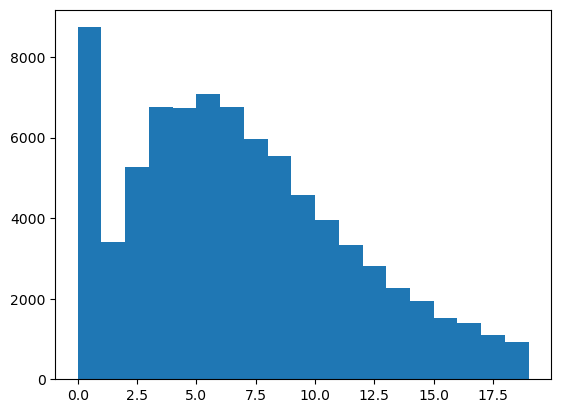

In [276]:
ratio=pRate_1[:,-1]/(pRate_1[:,-nclutbin-1]+0.01)
plt.hist(ratio/0.3,bins=np.arange(20))

In [324]:
#train the model
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#history=nn_model_class.fit(np.array(X_train_ext), np.array(y_train_cat), epochs=20, batch_size=32, verbose=1, \
#                     validation_data=(np.array(X_test_ext), np.array(y_test_cat)))
print(y_train_ext.mean(axis=0))
print(y_test_ext.mean(axis=0))
print(pRate_1[iy_train,-1].mean(axis=0))
print(pRate_1[iy_test,-1].mean(axis=0))
#stop
history=nn_model.fit(np.array(X_train_ext), np.array(y_train_ext), epochs=20, batch_size=32, verbose=1, \
                     validation_data=(np.array(X_test_ext), np.array(y_test_ext)))

0.0036424587
-0.008499066
1.3408227
1.3195597
Epoch 1/20
2711/2711 [==============================] - 1s 549us/step - loss: 0.6334 - mse: 0.6334 - mae: 0.4322 - val_loss: 39.3277 - val_mse: 39.3277 - val_mae: 5.1495
Epoch 2/20
2711/2711 [==============================] - 1s 543us/step - loss: 0.6327 - mse: 0.6327 - mae: 0.4322 - val_loss: 39.1094 - val_mse: 39.1094 - val_mae: 5.1102
Epoch 3/20
2711/2711 [==============================] - 1s 529us/step - loss: 0.6352 - mse: 0.6352 - mae: 0.4321 - val_loss: 39.3762 - val_mse: 39.3762 - val_mae: 5.1397
Epoch 4/20
2711/2711 [==============================] - 1s 537us/step - loss: 0.6308 - mse: 0.6308 - mae: 0.4314 - val_loss: 39.3360 - val_mse: 39.3360 - val_mae: 5.1369
Epoch 5/20
2711/2711 [==============================] - 1s 529us/step - loss: 0.6343 - mse: 0.6343 - mae: 0.4319 - val_loss: 38.9962 - val_mse: 38.9962 - val_mae: 5.1187
Epoch 6/20
2711/2711 [==============================] - 1s 530us/step - loss: 0.6336 - mse: 0.6336 - mae

In [289]:
history=nn_model_class.fit(np.array(X_train_ext), np.array(y_train_cat), epochs=10, batch_size=32, verbose=1, \
                     validation_data=(np.array(X_test_ext), np.array(y_test_cat)))

Epoch 1/10
2711/2711 [==============================] - 2s 652us/step - loss: 2.1010 - accuracy: 0.3714 - val_loss: 2.0973 - val_accuracy: 0.3698
Epoch 2/10
2711/2711 [==============================] - 2s 629us/step - loss: 2.1001 - accuracy: 0.3712 - val_loss: 2.0943 - val_accuracy: 0.3706
Epoch 3/10
2711/2711 [==============================] - 2s 628us/step - loss: 2.1006 - accuracy: 0.3716 - val_loss: 2.0950 - val_accuracy: 0.3690
Epoch 4/10
2711/2711 [==============================] - 2s 621us/step - loss: 2.1000 - accuracy: 0.3719 - val_loss: 2.0955 - val_accuracy: 0.3699
Epoch 5/10
2711/2711 [==============================] - 2s 611us/step - loss: 2.1002 - accuracy: 0.3716 - val_loss: 2.0949 - val_accuracy: 0.3695
Epoch 6/10
2711/2711 [==============================] - 2s 597us/step - loss: 2.1000 - accuracy: 0.3722 - val_loss: 2.0958 - val_accuracy: 0.3699
Epoch 7/10
2711/2711 [==============================] - 2s 605us/step - loss: 2.1002 - accuracy: 0.3714 - val_loss: 2.0966 -

In [327]:
y_=nn_model.predict(np.array(X_test_ext))
#convert iy_ to a single value
print(np.corrcoef(y_[:,0],pRate_1[iy_test,-1]))
print(y_[:,0].mean(),pRate_1[iy_test,-1].mean())


1162/1162 [==============================] - 0s 277us/step
[[1.         0.61640326]
 [0.61640326 1.        ]]
-0.01560644 1.3195597


In [17]:

cAlg=nc.Dataset("2A.GPM.DPR.V920211125.20230615-S141128-E144127.V07A.RT-H5")
sType=(cAlg['FS/PRE/landSurfaceType'][:,:])
lat=cAlg['FS']['Latitude'][:,:]
lon=cAlg['FS']['Longitude'][:,:]
import cartopy.crs as ccrs
print(lat.shape)
import cartopy.feature as cfeature


(2570, 49)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


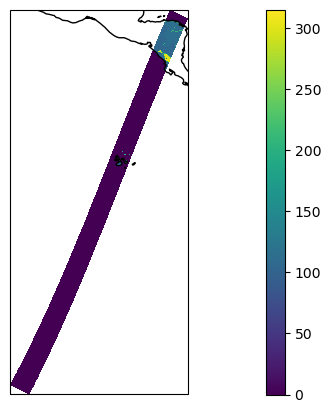

In [21]:

plt.figure(figsize=(20,5))
ax = plt.axes(projection=ccrs.PlateCarree())
nx=1500
plt.pcolormesh(lon[nx:,:],lat[nx:,:],sType[nx:,:],transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar()
print(sType[nx,:])

124751 0
123910 1
114483 2
106663 3
114004 4
107361 5
98384 6
73554 7
60145 8
60376 9
65307 10
66100 11
53265 12


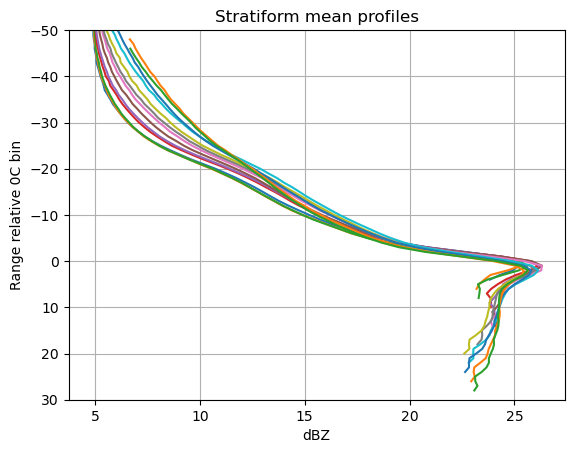

In [82]:

for k in range(13):
    zmLk=np.array(zmL[k])
    zmLk[zmLk<0]=0
    plt.plot(zmLk.mean(axis=0)[:75],np.arange(75)+2*k-70)
    #plt.plot(zmLk.mean(axis=0)[(160-2*k-90):(160-2*k-90)+1],np.arange(70-2*k,70-2*k+1)+2*k-70,'*')
    print(len(zmLk),k)
    plt.xlabel('dBZ')
    plt.ylabel('Range relative 0C bin')
plt.ylim(30,-50)
#plt.figure()
plt.grid()
plt.title('Stratiform mean profiles')
import xarray as xr
zkumx=[]
zkamx=[]
pRatex=[]
bzdx=xr.DataArray(160-np.arange(13)*2,dims=['nbins'])
d={}
for k in range(13):
    zkumx.append(xr.DataArray(np.array(zmL[k]),dims=['time%2.2i'%k,'range']))
    zkamx.append(xr.DataArray(np.array(zmKaL[k]),dims=['time%2.2i'%k,'range']))
    pRatex.append(xr.DataArray(np.array(pRateL[k]),dims=['time%2.2i'%k,'range']))
    d["zkum%2.2i"%k]=zkumx[k]
    d["zkam%2.2i"%k]=zkamx[k]
    d["pRate%2.2i"%k]=pRatex[k]
d["bzd"]=bzdx
ds=xr.Dataset(d)

#a=np.nonzero(pType[:,0]==1)
#b=np.nonzero(abs(bzd[a]-160)<3)
#print(len(b[0]))
#print(zm.shape)

In [83]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in ds.data_vars}
ds.to_netcdf('stratiformProfiles.nc',encoding=encoding)

269455


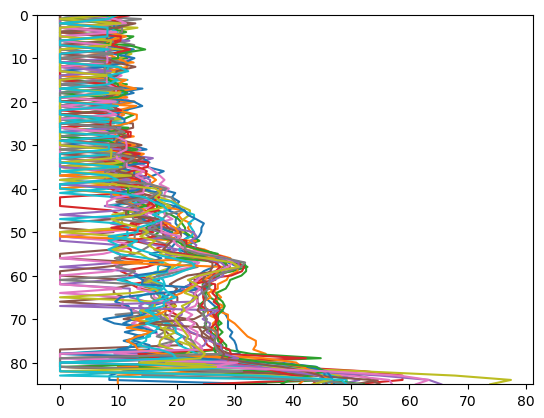

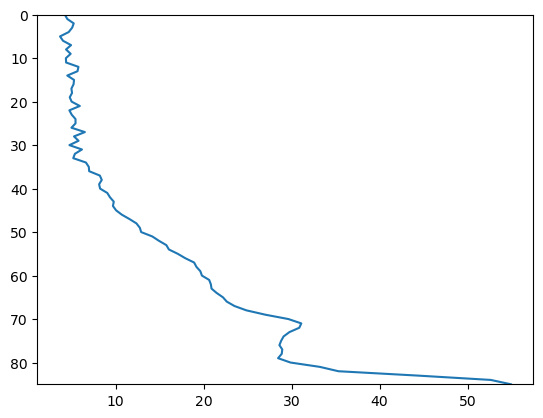

In [36]:
for i in range(100,130):
    plt.plot(zmL[i],np.arange(86))

plt.ylim(85,0)
plt.figure()
plt.plot(zmL[130:230,:].mean(axis=0),np.arange(86))
plt.ylim(85,0)
print(len(zmL))

In [21]:
print(bzd)

[137 173 174 ... 174 175 174]
